Margin: 1.4599030190123714
Support Vectors:
Support Vector 1: [-0.7884308  -0.52722864], Label = -1.0, alpha = 9.410483854695256e-10
Support Vector 2: [ 0.61168409 -2.02933329], Label = -1.0, alpha = 0.09999999967469468
Support Vector 3: [-2.0575449   0.06549604], Label = -1.0, alpha = 0.06754149942039074
Support Vector 4: [0.49425023 0.20961617], Label = -1.0, alpha = 1.2862403334940775e-10
Support Vector 5: [-0.29608334 -0.8751252 ], Label = -1.0, alpha = 7.860030701112338e-11
Support Vector 6: [1.1396598  0.03028167], Label = 1.0, alpha = 0.007875258184688455
Support Vector 7: [1.15202853 0.8352831 ], Label = 1.0, alpha = 2.205942626200994e-10
Support Vector 8: [1.27019047 0.59123312], Label = 1.0, alpha = 1.8503114163034075e-10
Support Vector 9: [0.43474793 1.82115309], Label = 1.0, alpha = 1.5474499191024016e-09


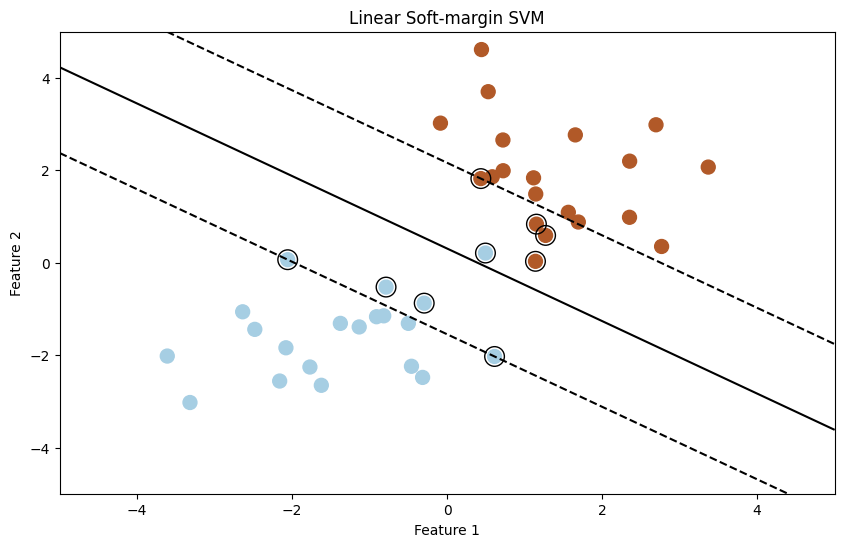

In [1]:
# CS771
# Soft-margin linear SVM by solving the dual problem (which is a quadratic program \alpha^\top 1 - 0.5 \alpha^\top G \alpha)
# To solve the QP (a convex maximization problem), we use the cvxopt package

import numpy as np
import cvxopt
import cvxopt.solvers
import matplotlib.pyplot as plt

# Step 1: Generate synthetic data with added noise
np.random.seed(0)
X1 = np.random.randn(20, 2) - [2, 2]
X2 = np.random.randn(20, 2) + [2, 2]
# Introduce some noise to make it non-linearly separable
X1 += np.random.randn(20, 2) * 0.5
X2 += np.random.randn(20, 2) * 0.5
X = np.vstack([X1, X2])
y = np.hstack([-np.ones(20), np.ones(20)])

# Number of data points
N = X.shape[0]

# Regularization parameter (C) for soft-margin SVM
# Higher value of C means fewer examples violating the constraints (thus closer to hard-margin SVM)
C = 0.1

# Compute the Gram matrix
Gtmp = np.dot(X, X.T) * np.outer(y, y)
G = cvxopt.matrix(Gtmp)
q = cvxopt.matrix(-np.ones(N))
# M and h specify alpha_i >= 0 constraints (M*alpha <= h)
M = cvxopt.matrix(np.vstack([-np.eye(N), np.eye(N)]))
h = cvxopt.matrix(np.hstack([np.zeros(N), C * np.ones(N)]))
# A and d specify sum(alpha_i * y_i) = 0 constraint (A*alpha = d)
A = cvxopt.matrix(y, (1, N))
d = cvxopt.matrix(0.0)

# Solve the quadratic programming problem
cvxopt.solvers.options['show_progress'] = False
solution = cvxopt.solvers.qp(G, q, M, h, A, d)

# Extract the Lagrange multipliers
alpha_optimal = np.array(solution['x']).flatten()

# Find the support vectors
support_vector_indices = np.where((alpha_optimal > 1e-5) & (alpha_optimal < C))[0]
support_vectors = X[support_vector_indices]
support_vector_labels = y[support_vector_indices]

# Calculate the weight vector w
w = np.sum((alpha_optimal[support_vector_indices] * support_vector_labels).reshape(-1, 1) * support_vectors, axis=0)

# Calculate b using one of the support vectors on the margin boundary (where alpha is exactly C)
margin_boundary_indices = np.where(np.abs(alpha_optimal - C) < 1e-5)[0]
chosen_support_vector = support_vectors[margin_boundary_indices[0]]
chosen_support_vector_label = support_vector_labels[margin_boundary_indices[0]]
b = chosen_support_vector_label - np.dot(w, chosen_support_vector)

# Calculate the margin
margin = 1 / np.linalg.norm(w)

# Print the margin value
print("Margin:", margin)

# Print the coordinates of the support vectors and their labels
print("Support Vectors:")
for i in range(len(support_vector_indices)):
    idx = support_vector_indices[i]
    print("Support Vector {}: {}, Label = {}, alpha = {}".format(i + 1, support_vectors[i], support_vector_labels[i], alpha_optimal[i]))

# Plot the data
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, marker='o', s=100)

# Plot the decision boundary
xx, yy = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
Z = np.dot(np.c_[xx.ravel(), yy.ravel()], w) + b
Z = Z.reshape(xx.shape)

plt.contour(xx, yy, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'], levels=[-1, 0, 1])
plt.scatter(support_vectors[:, 0], support_vectors[:, 1], s=200, facecolors='none', edgecolors='k')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Linear Soft-margin SVM')
plt.show()
